# Определение стоимости автомобилей

**Задание**

На основе исторических данных построить модель для быстрого определения рыночной стоимости автомобиля.

<br>

**Описание данных**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 12345
pd.options.display.float_format = "{:.2f}".format

In [3]:
def set_annotations_h(graph, digits=0):
    for p in graph.patches:
        graph.annotate(('{:.' + str(digits) + 'f}').format(p.get_width()),
                        (p.get_width() , p.get_y() + p.get_height()/2),
                        ha = 'left', va = 'center',
                        xytext = (9, 0),
                        textcoords = 'offset points')

In [4]:
def bold(string):
    return '\033[1m' + str(string) + '\033[0m'

In [5]:
data = pd.read_csv('/datasets/autos.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### DateCrawled — дата скачивания анкеты из базы

In [8]:
pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S').describe(datetime_is_numeric=True)

count                           354369
mean     2016-03-21 12:58:10.450648320
min                2016-03-05 14:06:22
25%                2016-03-13 11:52:33
50%                2016-03-21 17:50:55
75%                2016-03-29 14:37:20
max                2016-04-07 14:36:58
Name: DateCrawled, dtype: object

Значения - в пределах примерно месяца. Предположительно, столбец не несет полезной информации.

In [9]:
data = data.drop(['DateCrawled'], axis=1)

### Удаление дублей

Теперь, с учетом того, что одна и та же анкета могла быть скачана несколько раз, в разные моменты времени, можно удалить возможные повторяющиеся записи.

In [10]:
data = data.drop_duplicates()

### LastSeen — дата последней активности пользователя

In [11]:
pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S').describe(datetime_is_numeric=True)

count                           354280
mean     2016-03-29 23:50:29.177647360
min                2016-03-05 14:15:08
25%         2016-03-23 02:49:58.500000
50%                2016-04-03 15:15:31
75%      2016-04-06 10:08:37.750000128
max                2016-04-07 14:58:51
Name: LastSeen, dtype: object

Значения - в пределах примерно месяца. Предположительно, столбец не несет полезной информации.

In [12]:
data = data.drop(['LastSeen'], axis=1)

### DateCreated — дата создания анкеты

In [13]:
pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S').describe(datetime_is_numeric=True)

count                           354280
mean     2016-03-20 19:11:40.246133248
min                2014-03-10 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: DateCreated, dtype: object

Здесь присутствует некоторое количество значений с прошлых лет. В подобных объявлениях могут быть указаны неадекватные цены.

In [14]:
data['date_created'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data = data.drop(['DateCreated'], axis=1)

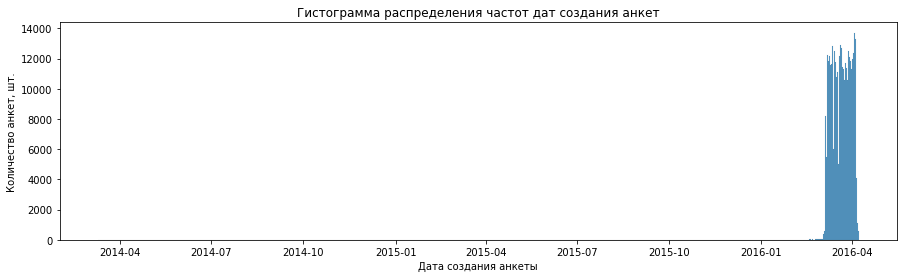

In [15]:
graph = sns.histplot(data=data, x='date_created', discrete=True)
graph.set(title='Гистограмма распределения частот дат создания анкет')
graph.set_xlabel('Дата создания анкеты')
graph.set_ylabel('Количество анкет, шт.')
graph.figure.set_figwidth(15)

In [16]:
data['date_created'].value_counts().sort_index()[:10]

2014-03-10    1
2015-03-20    1
2015-06-18    1
2015-08-07    1
2015-08-10    1
2015-09-04    2
2015-09-09    1
2015-11-02    1
2015-11-08    1
2015-11-10    1
Name: date_created, dtype: int64

In [17]:
data['date_created'].value_counts().sort_index()[-10:]

2016-03-29    12087
2016-03-30    11818
2016-03-31    11286
2016-04-01    11960
2016-04-02    12358
2016-04-03    13712
2016-04-04    13315
2016-04-05     4102
2016-04-06     1105
2016-04-07      549
Name: date_created, dtype: int64

In [18]:
data['date_created'].value_counts().sort_index()[60:90]

2016-02-19       22
2016-02-20       12
2016-02-21       23
2016-02-22       11
2016-02-23       12
2016-02-24       22
2016-02-25       20
2016-02-26       21
2016-02-27       22
2016-02-28       49
2016-02-29       46
2016-03-01       50
2016-03-02       37
2016-03-03      396
2016-03-04      601
2016-03-05     8185
2016-03-06     5505
2016-03-07    12239
2016-03-08    11853
2016-03-09    12150
2016-03-10    11543
2016-03-11    11646
2016-03-12    12840
2016-03-13     6014
2016-03-14    12475
2016-03-15    11802
2016-03-16    10800
2016-03-17    11114
2016-03-18     4986
2016-03-19    12191
Name: date_created, dtype: int64

Старых объявлений относительно мало, исключим их из рассмотрения.

In [19]:
data = data.query('date_created > "2016-03-02"')

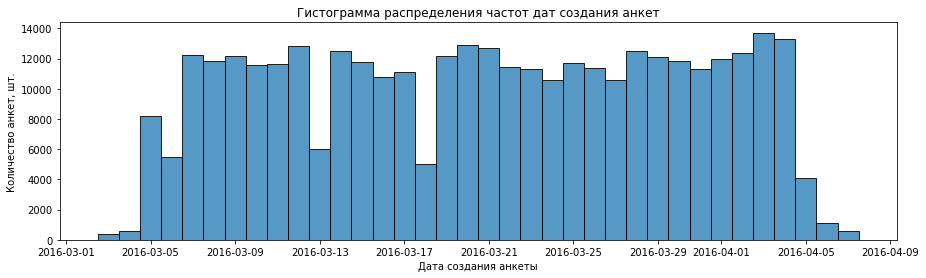

In [20]:
graph = sns.histplot(data=data, x='date_created', discrete=True)
graph.set(title='Гистограмма распределения частот дат создания анкет')
graph.set_xlabel('Дата создания анкеты')
graph.set_ylabel('Количество анкет, шт.')
graph.figure.set_figwidth(15)

In [21]:
data = data.drop(['date_created'], axis=1)

### Price — цена (евро)

In [22]:
data['Price'].describe()

count   353700.00
mean      4413.19
std       4512.93
min          0.00
25%       1050.00
50%       2700.00
75%       6400.00
max      20000.00
Name: Price, dtype: float64

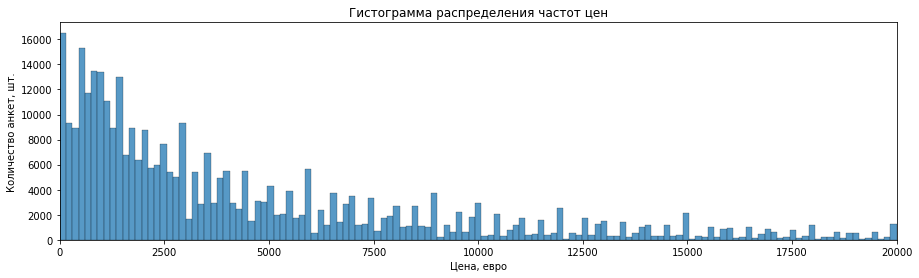

In [23]:
graph = sns.histplot(data=data, x='Price')
graph.set(title='Гистограмма распределения частот цен')
graph.set_xlabel('Цена, евро')
graph.set_ylabel('Количество анкет, шт.')
graph.set_xlim(data['Price'].min(), data['Price'].max())
graph.figure.set_figwidth(15)

Из общих соображений полагаем цену менее 100 евро неадекватной, и исключаем из рассмотрения такие анкеты.

In [24]:
data = data.query('Price >= 100')

### PostalCode — почтовый индекс владельца анкеты (пользователя)

Предположительно, столбец не несет полезной информации.

In [25]:
data = data.drop(['PostalCode'], axis=1)

### NumberOfPictures — количество фотографий автомобиля

Предположительно, столбец не несет полезной информации. Увеличение числа фотографий не увеличивает стоимость самого автомобиля.

In [26]:
data = data.drop(['NumberOfPictures'], axis=1)

### Model — модель автомобиля

Модель обязательно должна быть указана, иначе не понятно, что продается.

In [27]:
data = data.query('Model.notna() & Model != "other"')

In [28]:
np.array(sorted(data['Model'].unique()))

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

### Brand — марка автомобиля

In [29]:
np.array(sorted(data['Brand'].unique()))

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype='<U13')

### Repaired — была машина в ремонте или нет

In [30]:
data['Repaired'].value_counts(dropna=False).sort_index()

no     218089
yes     28595
NaN     53269
Name: Repaired, dtype: int64

Заменим значения "NaN" на "Unknown".

In [31]:
data['Repaired'] = data['Repaired'].fillna('Unknown')

### FuelType — тип топлива

In [32]:
data['FuelType'].value_counts(dropna=False).sort_index()

cng            495
electric        26
gasoline     88418
hybrid         128
lpg           4182
other           89
petrol      185527
NaN          21088
Name: FuelType, dtype: int64

"gasoline" и "petrol" - это одно и то же.

In [33]:
data.loc[data['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

In [34]:
data['FuelType'].value_counts(dropna=False).sort_index()

cng            495
electric        26
hybrid         128
lpg           4182
other           89
petrol      273945
NaN          21088
Name: FuelType, dtype: int64

"other" и "NaN" заменим на "Unknown".

In [35]:
data['FuelType'] = data['FuelType'].fillna('Unknown')
data.loc[data['FuelType'] == 'other', 'FuelType'] = 'Unknown'

In [36]:
data['FuelType'].value_counts(dropna=False).sort_index()

Unknown      21177
cng            495
electric        26
hybrid         128
lpg           4182
petrol      273945
Name: FuelType, dtype: int64

### Kilometer — пробег (км)

In [37]:
data['Kilometer'].value_counts(dropna=False).sort_index()

5000        3376
10000        824
20000       3128
30000       3686
40000       4234
50000       5385
60000       6500
70000       7463
80000       8737
90000      10107
100000     12547
125000     31651
150000    202315
Name: Kilometer, dtype: int64

### Power — мощность (л. с.)

In [38]:
data['Power'].describe()

count   299953.00
mean       112.05
std        186.29
min          0.00
25%         72.00
50%        105.00
75%        143.00
max      20000.00
Name: Power, dtype: float64

Из общих соображений будем считать, что мощность должна быть не меньше 20 л.с. и не больше 600 л.с.

In [39]:
data = data.query('Power >= 20 & Power <= 600')

### Gearbox — тип коробки передач

In [40]:
data['Gearbox'].value_counts(dropna=False).sort_index()

auto       52980
manual    214120
NaN         4823
Name: Gearbox, dtype: int64

Заменим значения "NaN" на "Unknown".

In [41]:
data['Gearbox'] = data['Gearbox'].fillna('Unknown')

In [42]:
data['Gearbox'].value_counts(dropna=False).sort_index()

Unknown      4823
auto        52980
manual     214120
Name: Gearbox, dtype: int64

### VehicleType — тип автомобильного кузова

In [43]:
data['VehicleType'].value_counts(dropna=False).sort_index()

bus            21666
convertible    16715
coupe          11291
other           1669
sedan          75456
small          64095
suv             8282
wagon          55364
NaN            17385
Name: VehicleType, dtype: int64

Заменим значения "NaN" и "other" на типичные для каждой модели автомобиля.

In [44]:
for brand in data['Brand'].unique():
    for model in data.query('Brand == @brand')['Model'].unique():
        mode = data.query('Brand == @brand & \
                           Model == @model & \
                           VehicleType.notna() & \
                           VehicleType != "other"'
                         )['VehicleType'].mode()
        
        data.loc[(data['Brand'] == brand) &
                 (data['Model'] == model) &
                 ((data['VehicleType'].isna()) | (data['VehicleType'] == "other")), 'VehicleType'
                ] = mode[0]

In [45]:
data['VehicleType'].value_counts(dropna=False).sort_index()

bus            24231
convertible    16867
coupe          11518
sedan          83936
small          69230
suv             8517
wagon          57624
Name: VehicleType, dtype: int64

### RegistrationYear — год регистрации автомобиля

In [46]:
data['RegistrationYear'].describe()

count   271923.00
mean      2003.76
std         20.63
min       1500.00
25%       1999.00
50%       2004.00
75%       2008.00
max       8200.00
Name: RegistrationYear, dtype: float64

In [47]:
data['RegistrationYear'].value_counts(dropna=False).sort_index()[:10]

1500    1
1800    1
1910    4
1938    1
1956    2
1958    1
1959    4
1960    8
1961    5
1962    3
Name: RegistrationYear, dtype: int64

In [48]:
data['RegistrationYear'].value_counts(dropna=False).sort_index()[60:]

2013    3553
2014    2122
2015     914
2016    5236
2017    6224
2018    2394
2019       9
2900       1
4000       2
5000       3
5911       2
8200       1
Name: RegistrationYear, dtype: int64

Исключим из рассмотрения некорректные значения.

In [49]:
data = data.query('RegistrationYear >= 1910 & RegistrationYear <= 2016')

### RegistrationMonth — месяц регистрации автомобиля

In [50]:
data['RegistrationMonth'].value_counts(dropna=False).sort_index()

0     14427
1     17917
2     16753
3     27211
4     22897
5     22883
6     24515
7     21189
8     17584
9     18974
10    20714
11    19142
12    19079
Name: RegistrationMonth, dtype: int64

Заменим значения "0" на "1".

In [51]:
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

Заменим столбцы года и месяца на единый столбец возраста автомобиля в месяцах.

In [52]:
data['age_in_months'] = (2016 - data['RegistrationYear']) * 12 + (4 - data['RegistrationMonth'])
data = data.query('age_in_months >= 0')

data = data.drop(['RegistrationYear', 'RegistrationMonth'], axis=1)

### Общая предобработка

Преобразуем наименования столбцов в snake case.

In [53]:
data.columns = (data.columns
                .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                .str.lower()
               )

### Итог

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260465 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   price          260465 non-null  int64 
 1   vehicle_type   260465 non-null  object
 2   gearbox        260465 non-null  object
 3   power          260465 non-null  int64 
 4   model          260465 non-null  object
 5   kilometer      260465 non-null  int64 
 6   fuel_type      260465 non-null  object
 7   brand          260465 non-null  object
 8   repaired       260465 non-null  object
 9   age_in_months  260465 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 21.9+ MB


In [55]:
data.head()

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,age_in_months
2,9800,suv,auto,163,grand,125000,petrol,jeep,Unknown,140
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,178
4,3600,small,manual,69,fabia,90000,petrol,skoda,no,93
5,650,sedan,manual,102,3er,150000,petrol,bmw,yes,246
6,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no,140


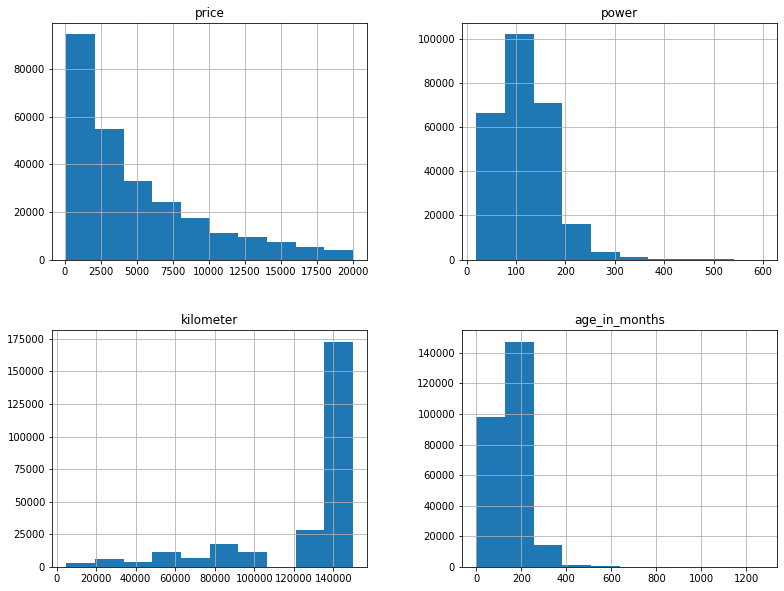

In [56]:
data.hist(figsize=(13, 10));

## Подбор оптимальных параметров моделей

In [57]:
features = data.drop(['price'], axis=1)
target = data['price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [58]:
cat_features = X_train.select_dtypes(include='object').columns.to_list()

col_transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        ['brand', 'model']
    ),
    (
        OneHotEncoder(handle_unknown='ignore'),
        ['vehicle_type', 'repaired', 'gearbox', 'fuel_type']
    ),    
    remainder='passthrough'
)

### RandomForestRegressor

In [59]:
model = RandomForestRegressor(random_state=RANDOM_STATE)

pipe = make_pipeline(col_transformer, model)

param_grid = {
    'randomforestregressor__max_depth': range(18, 21)
}

grid = GridSearchCV(
    pipe, 
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', 
    cv=3,
    verbose=2
)

In [60]:
grid.fit(X_train, y_train);

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ................randomforestregressor__max_depth=18; total time=  42.3s
[CV] END ................randomforestregressor__max_depth=18; total time=  42.9s
[CV] END ................randomforestregressor__max_depth=18; total time=  42.5s
[CV] END ................randomforestregressor__max_depth=19; total time=  44.0s
[CV] END ................randomforestregressor__max_depth=19; total time=  43.7s
[CV] END ................randomforestregressor__max_depth=19; total time=  44.0s
[CV] END ................randomforestregressor__max_depth=20; total time=  45.1s
[CV] END ................randomforestregressor__max_depth=20; total time=  43.0s
[CV] END ................randomforestregressor__max_depth=20; total time=  44.6s


In [61]:
print('Best score:', bold(grid.best_score_ * -1))
print('Best params:', grid.best_params_)

Best score: 1506.6504278827822
Best params: {'randomforestregressor__max_depth': 19}


### GradientBoostingRegressor

In [62]:
model = GradientBoostingRegressor(random_state=RANDOM_STATE)

pipe = make_pipeline(col_transformer, model)

param_grid = {
    'gradientboostingregressor__max_depth': range(10, 13)
}

grid = GridSearchCV(
    pipe, 
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', 
    cv=3,
    verbose=2
)

In [63]:
grid.fit(X_train, y_train);

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ............gradientboostingregressor__max_depth=10; total time=  47.5s
[CV] END ............gradientboostingregressor__max_depth=10; total time=  47.3s
[CV] END ............gradientboostingregressor__max_depth=10; total time=  47.9s
[CV] END ............gradientboostingregressor__max_depth=11; total time=  51.5s
[CV] END ............gradientboostingregressor__max_depth=11; total time=  52.0s
[CV] END ............gradientboostingregressor__max_depth=11; total time=  51.3s
[CV] END ............gradientboostingregressor__max_depth=12; total time=  51.5s
[CV] END ............gradientboostingregressor__max_depth=12; total time=  47.1s
[CV] END ............gradientboostingregressor__max_depth=12; total time=  47.5s


In [64]:
print('Best score:', bold(grid.best_score_ * -1))
print('Best params:', grid.best_params_)

Best score: 1466.5339549960597
Best params: {'gradientboostingregressor__max_depth': 11}


### LGBMRegressor

In [65]:
model = LGBMRegressor(random_state=RANDOM_STATE)

pipe = make_pipeline(col_transformer, model)

param_grid = {
    'lgbmregressor__max_depth': [16, None],
    'lgbmregressor__learning_rate': [0.35, 0.5]
}

grid = GridSearchCV(
    pipe, 
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', 
    cv=3,
    verbose=2
)

In [66]:
grid.fit(X_train, y_train);

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END lgbmregressor__learning_rate=0.35, lgbmregressor__max_depth=16; total time=   3.3s
[CV] END lgbmregressor__learning_rate=0.35, lgbmregressor__max_depth=16; total time=   3.3s
[CV] END lgbmregressor__learning_rate=0.35, lgbmregressor__max_depth=16; total time=   3.2s
[CV] END lgbmregressor__learning_rate=0.35, lgbmregressor__max_depth=None; total time=   3.0s
[CV] END lgbmregressor__learning_rate=0.35, lgbmregressor__max_depth=None; total time=   3.4s
[CV] END lgbmregressor__learning_rate=0.35, lgbmregressor__max_depth=None; total time=   3.8s
[CV] END lgbmregressor__learning_rate=0.5, lgbmregressor__max_depth=16; total time=   3.3s
[CV] END lgbmregressor__learning_rate=0.5, lgbmregressor__max_depth=16; total time=   3.9s
[CV] END lgbmregressor__learning_rate=0.5, lgbmregressor__max_depth=16; total time=   5.0s
[CV] END lgbmregressor__learning_rate=0.5, lgbmregressor__max_depth=None; total time=   3.4s
[CV] END lgbmreg

In [67]:
print('Best score:', bold(grid.best_score_ * -1))
print('Best params:', grid.best_params_)

Best score: 1523.5385119865434
Best params: {'lgbmregressor__learning_rate': 0.5, 'lgbmregressor__max_depth': 16}


### CatBoostRegressor

In [68]:
model = CatBoostRegressor(max_depth=16,
                          iterations=100,
                          logging_level='Silent',
                          random_state=RANDOM_STATE
)

pipe = make_pipeline(col_transformer, model)

param_grid = {
    'catboostregressor__learning_rate': [0.25, 0.3]
}

grid = GridSearchCV(
    pipe, 
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', 
    cv=3,
    verbose=2
)

In [69]:
grid.fit(X_train, y_train);

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ..............catboostregressor__learning_rate=0.25; total time= 2.6min
[CV] END ..............catboostregressor__learning_rate=0.25; total time= 2.6min
[CV] END ..............catboostregressor__learning_rate=0.25; total time= 2.6min
[CV] END ...............catboostregressor__learning_rate=0.3; total time= 2.7min
[CV] END ...............catboostregressor__learning_rate=0.3; total time= 2.6min
[CV] END ...............catboostregressor__learning_rate=0.3; total time= 2.7min


In [70]:
print('Best score:', bold(grid.best_score_ * -1))
print('Best params:', grid.best_params_)

Best score: 1479.9477928879362
Best params: {'catboostregressor__learning_rate': 0.25}


#### CatBoostRegressor со встроенным обработчиком категориальных признаков

In [71]:
model = CatBoostRegressor(max_depth=16,
                          iterations=100,
                          cat_features=cat_features,
                          logging_level='Silent',
                          random_state=RANDOM_STATE
)

param_grid = {
    'learning_rate': [0.25, 0.3]
}

grid = GridSearchCV(
    model, 
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error', 
    cv=3,
    verbose=2
)

In [72]:
grid.fit(X_train, y_train);

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END .................................learning_rate=0.25; total time= 2.4min
[CV] END .................................learning_rate=0.25; total time= 2.4min
[CV] END .................................learning_rate=0.25; total time= 2.5min
[CV] END ..................................learning_rate=0.3; total time= 2.5min
[CV] END ..................................learning_rate=0.3; total time= 2.5min
[CV] END ..................................learning_rate=0.3; total time= 2.5min


In [73]:
print('Best score:', bold(grid.best_score_ * -1))
print('Best params:', grid.best_params_)

Best score: 1487.9464274157162
Best params: {'learning_rate': 0.25}


### Итог

Итоги подбора оптимальных параметров моделей, и полученные с их помощью результаты представлены в следующей таблице.

<table align=left>
    <tr>
        <th><div style="text-align:center;">Модель</div></th>
        <th><div style="text-align:center;">Параметры</div></th>
        <th><div style="text-align:center;">RMSE</div></th>
    </tr>
    <tr>
        <td><div style="text-align:left;">RandomForestRegressor</div></td>
        <td><div style="text-align:center;">max_depth: 19</div></td>
        <td><div style="text-align:center;">1507</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;"><b>GradientBoostingRegressor</b></div></td>
        <td><div style="text-align:center;">max_depth: 11</div></td>
        <td><div style="text-align:center;"><b>1467</b></div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;">LGBMRegressor</div></td>
        <td><div style="text-align:center;">learning_rate: 0.5<br>max_depth: 16</div></td>
        <td><div style="text-align:center;">1524</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;">CatBoostRegressor</div></td>
        <td><div style="text-align:center;">max_depth: 16<br>iterations: 100<br>learning_rate: 0.25</div></td>
        <td><div style="text-align:center;">1480</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;">CatBoostRegressor (cat_features)</div></td>
        <td><div style="text-align:center;">max_depth: 16<br>iterations: 100<br>learning_rate: 0.25</div></td>
        <td><div style="text-align:center;">1488</div></td>
    </tr>
</table>

Лучший результат у модели GradientBoostingRegressor с параметром max_depth=11<br>
RMSE: 1467

## Анализ скорости работы моделей

### RandomForestRegressor

In [74]:
model_rfr = RandomForestRegressor(max_depth=19, random_state=RANDOM_STATE)

pipe_rfr = make_pipeline(col_transformer, model_rfr)

In [75]:
%%time
pipe_rfr.fit(X_train, y_train);
pass

CPU times: user 1min 3s, sys: 151 ms, total: 1min 3s
Wall time: 1min 3s


In [76]:
%%time
for _ in range(1000):
    pred = pipe_rfr.predict(X_train[0:1])

CPU times: user 8.54 s, sys: 19.3 ms, total: 8.56 s
Wall time: 8.57 s


### GradientBoostingRegressor

In [77]:
model_gbr = GradientBoostingRegressor(max_depth=11, random_state=RANDOM_STATE)

pipe_gbr = make_pipeline(col_transformer, model_gbr)

In [78]:
%%time
pipe_gbr.fit(X_train, y_train);
pass

CPU times: user 1min 16s, sys: 116 ms, total: 1min 16s
Wall time: 1min 17s


In [79]:
%%time
for _ in range(1000):
    pred = pipe_gbr.predict(X_train[0:1])

CPU times: user 3.27 s, sys: 10 ms, total: 3.28 s
Wall time: 3.28 s


### LGBMRegressor

In [80]:
model_lgbmr = LGBMRegressor(max_depth=16, learning_rate=0.5, random_state=RANDOM_STATE)

pipe_lgbmr = make_pipeline(col_transformer, model_lgbmr)

In [81]:
%%time
pipe_lgbmr.fit(X_train, y_train);
pass

CPU times: user 1min 40s, sys: 0 ns, total: 1min 40s
Wall time: 1min 41s


In [82]:
%%time
for _ in range(1000):
    pred = pipe_lgbmr.predict(X_train[0:1])

CPU times: user 22.9 s, sys: 0 ns, total: 22.9 s
Wall time: 23 s


### CatBoostRegressor

In [83]:
model_cbr = CatBoostRegressor(max_depth=16,
                              iterations=100,
                              learning_rate=0.25,
                              random_state=RANDOM_STATE,
                              logging_level='Silent'
)

pipe_cbr = make_pipeline(col_transformer, model_cbr)

In [84]:
%%time
pipe_cbr.fit(X_train, y_train);
pass

CPU times: user 1min 27s, sys: 1min 7s, total: 2min 35s
Wall time: 2min 36s


In [85]:
%%time
for _ in range(1000):
    pred = pipe_cbr.predict(X_train[0:1])

CPU times: user 3.48 s, sys: 19 ms, total: 3.5 s
Wall time: 3.51 s


#### CatBoostRegressor со встроенным обработчиком категориальных признаков

In [86]:
model_cbrc = CatBoostRegressor(max_depth=16,
                               iterations=100,
                               learning_rate=0.25,
                               cat_features=cat_features,
                               random_state=RANDOM_STATE,
                               logging_level='Silent'
)

In [87]:
%%time
model_cbrc.fit(X_train, y_train)
pass

CPU times: user 1min 45s, sys: 48.5 s, total: 2min 34s
Wall time: 2min 34s


In [88]:
%%time
for _ in range(1000):
    pred = model_cbrc.predict(X_train[0:1])

CPU times: user 882 ms, sys: 639 µs, total: 883 ms
Wall time: 889 ms


### Итог

Итоговые результаты приведены в следующей таблице.

<table align=left>
    <tr>
        <th><div style="text-align:center;">Модель</div></th>
        <th><div style="text-align:center;">Параметры</div></th>
        <th><div style="text-align:center;">RMSE</div></th>
        <th><div style="text-align:center;">Время обучения, с</div></th>
        <th><div style="text-align:center;">Время предсказания одного значения, мс</div></th>
    </tr>
    <tr>
        <td><div style="text-align:left;">RandomForestRegressor</div></td>
        <td><div style="text-align:center;">max_depth: 19</div></td>
        <td><div style="text-align:center;">1507</div></td>
        <td><div style="text-align:center;"><b>69</b></div></td>
        <td><div style="text-align:center;">9.4</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;"><b>GradientBoostingRegressor</b></div></td>
        <td><div style="text-align:center;">max_depth: 11</div></td>
        <td><div style="text-align:center;"><b>1467</b></div></td>
        <td><div style="text-align:center;">92</div></td>
        <td><div style="text-align:center;">3.6</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;">LGBMRegressor</div></td>
        <td><div style="text-align:center;">learning_rate: 0.5<br>max_depth: 16</div></td>
        <td><div style="text-align:center;">1524</div></td>
        <td><div style="text-align:center;">355</div></td>
        <td><div style="text-align:center;">60.0</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;">CatBoostRegressor</div></td>
        <td><div style="text-align:center;">max_depth: 16<br>iterations: 100<br>learning_rate: 0.25</div></td>
        <td><div style="text-align:center;">1480</div></td>
        <td><div style="text-align:center;">176</div></td>
        <td><div style="text-align:center;">4.8</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;">CatBoostRegressor (cat_features)</div></td>
        <td><div style="text-align:center;">max_depth: 16<br>iterations: 100<br>learning_rate: 0.25</div></td>
        <td><div style="text-align:center;">1488</div></td>
        <td><div style="text-align:center;">157</div></td>
        <td><div style="text-align:center;"><b>0.9</b></div></td>
    </tr>
</table>

Лучшие результаты по качеству - у модели GradientBoostingRegressor.<br>
По скорости обучения и предсказания она на вторых местах, но эти ее показатели представляются все же достаточно малыми, чтобы выбрать данную модель в качестве итоговой.

In [89]:
models_list = ['RandomForestRegressor',
               'GradientBoostingRegressor',
               'LGBMRegressor',
               'CatBoostRegressor',
               'CatBoostRegressor\n(cat_features)'
              ]

rmse_list = [1507, 1467, 1524, 1480, 1488]
train_time_list = [69, 92, 355, 176, 157]
pred_time_list = [9.4, 3.6, 60.0, 4.8, 0.9]

## Проверка лучшей модели на тестовой выборке

In [90]:
pred = pipe_gbr.predict(X_test)

In [91]:
rmse = mean_squared_error(y_test, pred, squared=False)
print('RMSE:', bold(rmse))

RMSE: 1445.3393280605994


Результат - лучше, чем на обучающей выборке.

### Сравнение с Dummy-моделью

In [92]:
model_dummy = DummyRegressor(strategy="median")
model_dummy.fit(X_train, y_train)
pred = model_dummy.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
print('RMSE:', rmse)

RMSE: 4889.393551621701


Результат Dummy-модели хуже, чем у выбранной модели GradientBoostingRegressor.

## Выводы

Для решения задачи были использованы следующие модели:
* Случайный лес (RandomForestRegressor)
* Модели градиентного бустинга:
  * GradientBoostingRegressor
  * LGBMRegressor
  * CatBoostRegressor 
  * CatBoostRegressor (с использованием встроенного обработчика категориальных признаков)

Итоговые результаты приведены в следующей таблице.

<table align=left>
    <tr>
        <th><div style="text-align:center;">Модель</div></th>
        <th><div style="text-align:center;">Параметры</div></th>
        <th><div style="text-align:center;">RMSE</div></th>
        <th><div style="text-align:center;">Время обучения, с</div></th>
        <th><div style="text-align:center;">Время предсказания одного значения, мс</div></th>
    </tr>
    <tr>
        <td><div style="text-align:left;">RandomForestRegressor</div></td>
        <td><div style="text-align:center;">max_depth: 19</div></td>
        <td><div style="text-align:center;">1507</div></td>
        <td><div style="text-align:center;"><b>69</b></div></td>
        <td><div style="text-align:center;">9.4</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;"><b>GradientBoostingRegressor</b></div></td>
        <td><div style="text-align:center;">max_depth: 11</div></td>
        <td><div style="text-align:center;"><b>1467</b></div></td>
        <td><div style="text-align:center;">92</div></td>
        <td><div style="text-align:center;">3.6</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;">LGBMRegressor</div></td>
        <td><div style="text-align:center;">learning_rate: 0.5<br>max_depth: 16</div></td>
        <td><div style="text-align:center;">1524</div></td>
        <td><div style="text-align:center;">355</div></td>
        <td><div style="text-align:center;">60.0</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;">CatBoostRegressor</div></td>
        <td><div style="text-align:center;">max_depth: 16<br>iterations: 100<br>learning_rate: 0.25</div></td>
        <td><div style="text-align:center;">1480</div></td>
        <td><div style="text-align:center;">176</div></td>
        <td><div style="text-align:center;">4.8</div></td>
    </tr>
    <tr>
        <td><div style="text-align:left;">CatBoostRegressor (cat_features)</div></td>
        <td><div style="text-align:center;">max_depth: 16<br>iterations: 100<br>learning_rate: 0.25</div></td>
        <td><div style="text-align:center;">1488</div></td>
        <td><div style="text-align:center;">157</div></td>
        <td><div style="text-align:center;"><b>0.9</b></div></td>
    </tr>
</table>

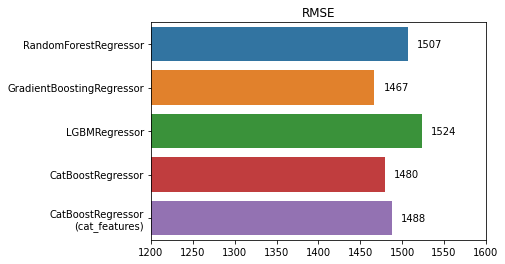

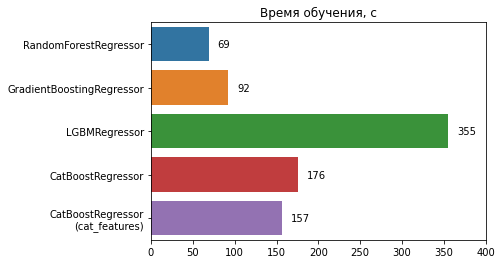

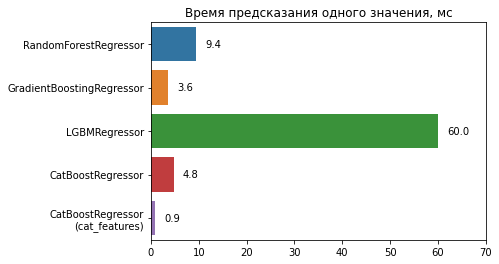

In [93]:
graph = sns.barplot(y=models_list, x=rmse_list)
graph.set(title="RMSE")
graph.set(xlim=(1200, 1600))
set_annotations_h(graph)
plt.show()

graph = sns.barplot(y=models_list, x=train_time_list)
graph.set(title="Время обучения, с")
graph.set(xlim=(0, 400))
set_annotations_h(graph)
plt.show()

graph = sns.barplot(y=models_list, x=pred_time_list)
graph.set(title="Время предсказания одного значения, мс")
graph.set(xlim=(0, 70))
set_annotations_h(graph, 1)
plt.show()

Лучшее качество предсказания - у модели <b>GradientBoostingRegressor</b>:<br>
RMSE: <b>1467</b> (на тестовой выборке: <b>1445</b>).<br>
Среднее время предсказания одного значения: <b>3.6 мс</b>.<br>
Время обучения сравнимо с наилучшим и составляет <b>92 с</b>.<br>

Быстрее прочих обучается модель случайного леса: за 69 с.<br>
Лучшее время предсказания - у модели CatBoostRegressor с использованием встроенного обработчика категориальных признаков: 0.9 мс.

Модель CatBoostRegressor при использовании встроенного обработчика категориальных признаков обучается и предсказывает быстрее, чем без него, но качество предсказания при этом незначительно ухудшается: RMSE увеличивается с 1480 до 1488.